### MR files are nested in directories, make the structure flat

In [86]:
dataset_base_path = "/media/jfallmann/T9/University/master_thesis/dataset"

mri_raw_path = f"{dataset_base_path}/mri/raw"
mri_base_path = f"{dataset_base_path}/mri"
snp_raw_path = f"{dataset_base_path}/snp/raw"
mri_bids_path = f"{dataset_base_path}/mri/bids"
mri_fastsurfer_out = f"{dataset_base_path}/mri/out_fastsurfer"

In [47]:
import glob

# Get all the MR files
mr_input_files = glob.glob(f'{mri_raw_path}/**/*.nii', recursive=True)
print(f"Found {len(mr_input_files)} MR files")

Found 3209 MR files


In [48]:
## are there any directories with multiple files?
from collections import defaultdict
import os

dir_files = defaultdict(list)
for file in mr_input_files:
    dir_files[os.path.dirname(file)].append(file)

for k, v in dir_files.items():
    if len(v) > 1:
        print(k, v)

print("Done")

Done


In [ ]:
def clean_id(id: str) -> str:
    return id.replace("_", "").replace(".", "").replace("-", "").lower()

In [54]:
import re
# Get all subject ids where genome data is available
genome_files = glob.glob(f'{snp_raw_path}/**/*.vcf', recursive=True)
genome_split_regex = r'(.*)_SNPs'
genome_subjects = [re.search(genome_split_regex, os.path.basename(file)).group(1) for file in genome_files]
genome_subjects = [clean_id(subject) for subject in genome_subjects]
print(f"Found {len(genome_subjects)} subjects with genome data")

Found 809 subjects with genome data


In [55]:
# files have the structure ADNI/<subject-id>/<preprocessing-name>/<session-id>/<some-id>/<filename>.nii
# we want to group files by subject id, choose the folder with the longest name and use the most recent session
# if there are multiple files in the same session, choose the one with the longest name
# session name is a date string in the format YYYY-MM-DD_THH_MM.0

files_per_subject = defaultdict(str)

for file in mr_input_files:
    file_splits = file.split('/')

    adni_index = file_splits.index('ADNI')
    subject_id = clean_id(file_splits[adni_index + 1])
    preprocessing_name = file_splits[adni_index + 2]
    session_id =  file_splits[adni_index + 3]

    # skip if subject has no genome data
    if subject_id not in genome_subjects:
        print(f"Skipping {subject_id} as no genome data is available")
        continue

    # get current file stored for subject
    current_file = files_per_subject.get(subject_id, None)
    if current_file is None:
        files_per_subject[subject_id] = file
    else:
        current_file_splits = current_file.split('/')
        current_session_id = current_file_splits[adni_index + 3]
        current_preprocessing_name = current_file_splits[adni_index + 2]

        if session_id > current_session_id:
            files_per_subject[subject_id] = file
        elif session_id == current_session_id:
            if len(preprocessing_name) > len(current_preprocessing_name):
                files_per_subject[subject_id] = file

print(f"Found {len(files_per_subject)} subjects with MR data")

Skipping 023s0376 as no genome data is available
Skipping 023s0376 as no genome data is available
Skipping 023s0376 as no genome data is available
Skipping 023s0376 as no genome data is available
Skipping 023s0376 as no genome data is available
Skipping 035s0292 as no genome data is available
Skipping 035s0292 as no genome data is available
Skipping 082s0363 as no genome data is available
Skipping 002s0295 as no genome data is available
Skipping 002s0295 as no genome data is available
Skipping 941s1194 as no genome data is available
Skipping 016s0538 as no genome data is available
Skipping 016s0538 as no genome data is available
Skipping 016s0538 as no genome data is available
Skipping 016s0538 as no genome data is available
Skipping 128s0715 as no genome data is available
Skipping 128s0715 as no genome data is available
Skipping 009s0751 as no genome data is available
Skipping 128s1242 as no genome data is available
Skipping 128s1242 as no genome data is available
Skipping 128s1242 as

In [56]:
# create a bids dataset in data/mri
# folder structure should be data/mri/adni_thesis/sub-<subject_id>/ses-<session_id>

if not os.path.exists(mri_bids_path):
    os.makedirs(mri_bids_path)

for subject_id, filepath in files_per_subject.items():
    file_splits = filepath.split('/')

    adni_index = file_splits.index('ADNI')

    subject_id_clean = subject_id
    session_id =  clean_id(file_splits[adni_index + 3])

    folder = f'{mri_bids_path}/sub-{subject_id}/ses-{session_id}/anat'
    if not os.path.exists(folder):
        os.makedirs(folder)

    new_file = f'{folder}/sub-{subject_id}_ses-{session_id}_T1w.nii'
    os.rename(filepath, new_file)

print("Done, created BIDS dataset")

In [64]:
# get all subject ids in the bids dataset
bids_subjects = glob.glob(f'{mri_bids_path}/*')
bids_subjects = [os.path.basename(subject).replace("sub-","") for subject in bids_subjects]
print(f"Found {len(bids_subjects)} subjects in BIDS dataset")

Found 244 subjects in BIDS dataset


In [76]:
import pandas as pd

tabular_data = pd.read_csv(f"{dataset_base_path}/tables/Cohort_18_My_Table_28Dec2024.csv")
selected_subjects = tabular_data[tabular_data['subject_id'].map(lambda x: clean_id(x)).isin(bids_subjects)]

# get highest value of Diagnosis per subject
selected_subjects = selected_subjects.sort_values('DIAGNOSIS', ascending=False).drop_duplicates('subject_id')

# count unique values in diagnosis column
selected_subjects['DIAGNOSIS'].value_counts()

DIAGNOSIS
3.0    109
2.0     77
1.0     58
Name: count, dtype: int64

## Create batch file for fastsurfer

In [82]:
# fastsurfer batchfile format is as follows:
# <subject-id>=<path-to-mr-file>

mr_files = glob.glob(f'{mri_bids_path}/**/*.nii', recursive=True)
docker_filepath = "/data"

with open(f"{mri_bids_path}/fastsurfer_batch.txt", "w") as f:
    for filepath in mr_files:
        # replace current filesystem path with docker path
        docker_file = filepath.replace(mri_bids_path, docker_filepath)
        file_splits = docker_file.split('/')
        subject_id = clean_id(file_splits[2].replace("sub-", ""))
        f.write(f"{subject_id}={docker_file}\n")

In [ ]:
# Run preprocessing pipeline
#! smriprep-docker ./data/mri/adni_thesis ./data_processed/mri participant --fs-license-file ./license.txt --ncpus 4 --skull-strip-mode force

In [87]:
# create fastsurfer output directory
if not os.path.exists(mri_fastsurfer_out):
    os.makedirs(mri_fastsurfer_out)

In [88]:
!docker run --gpus all -v /media/jfallmann/T9/University/master_thesis/dataset/mri/bids:/data -v /media/jfallmann/T9/University/master_thesis/dataset/mri/out_fastsurfer:/output -v /media/jfallmann/T9/University/master_thesis/license:/fs_license --entrypoint "/fastsurfer/brun_fastsurfer.sh" --rm --user $(id -u):$(id -g) deepmi/fastsurfer:latest --fs_license /fs_license/license.txt --subject_list /data/fastsurfer_batch.txt --sd /output --parallel --3T --seg_only

/fastsurfer/brun_fastsurfer.sh --fs_license /fs_license/license.txt --subject_list /data/fastsurfer_batch.txt --sd /output --parallel --3T --seg_only
Sat, 28 Dec 2024 18:32:53 +0000

INFO: run_fastsurfer not explicitly specified, using $FASTSURFER_HOME/run_fastsurfer.sh.
023s0058=/data/sub-023s0058/ses-201003191315240/anat/sub-023s0058_ses-201003191315240_T1w.nii 023s0042=/data/sub-023s0042/ses-201003180903160/anat/sub-023s0042_ses-201003180903160_T1w.nii 023s0061=/data/sub-023s0061/ses-201002251010440/anat/sub-023s0061_ses-201002251010440_T1w.nii 023s0126=/data/sub-023s0126/ses-201003040827400/anat/sub-023s0126_ses-201003040827400_T1w.nii 023s0217=/data/sub-023s0217/ses-201003121000270/anat/sub-023s0217_ses-201003121000270_T1w.nii 023s0625=/data/sub-023s0625/ses-201010070930050/anat/sub-023s0625_ses-201010070930050_T1w.nii 011s0021=/data/sub-011s0021/ses-200810231309110/anat/sub-011s0021_ses-200810231309110_T1w.nii 011s0023=/data/sub-011s0023/ses-201001061108420/anat/sub-011s0023_ses-

In [21]:
import nibabel as nib

data = nib.load("data/mri/adni_thesis/sub-002S0413/ses-201205151642320/anat/sub-002S0413_ses-201205151642320_T1w.nii")
data_processed = nib.load("data_processed/mri/smriprep/sub-002S0413/ses-201205151642320/anat/sub-002S0413_ses-201205151642320_desc-preproc_T1w.nii.gz")

print(data.shape)
print(data_processed.shape)

(170, 256, 256)
(170, 256, 256)


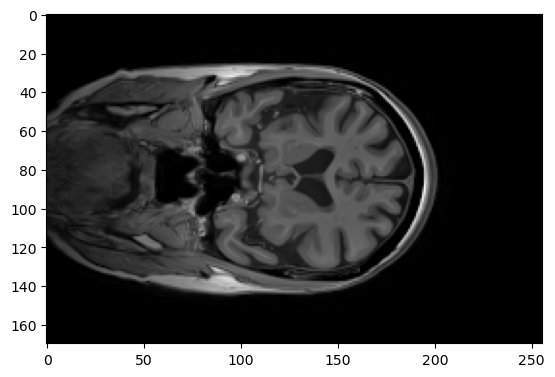

In [22]:
import matplotlib.pyplot as plt

plt.imshow(data_processed.get_fdata()[:, 150, :], cmap='gray')

In [11]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import transforms


%matplotlib inline

def plot_func(slice):
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))  # Create side-by-side subplots

    tr = transforms.Affine2D().rotate_deg(90)

    # Plot the first image
    axes[0].imshow(data.get_fdata()[:, :, slice], cmap='gray', origin='lower')
    axes[0].set_title(f'Image basic preprocessing - Slice {slice}')
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(data_processed.get_fdata()[:, :, slice], cmap='gray', origin='lower')
    axes[1].set_title(f'Image preprocessed - Slice {slice}')
    axes[1].axis('off')

    plt.show()

# Interactive slider
interact(
    plot_func,
    slice=widgets.IntSlider(value=100, min=0, max=data.shape[1]-1, step=5)
)

interactive(children=(IntSlider(value=100, description='slice', max=255, step=5), Output()), _dom_classes=('wi…

<function __main__.plot_func(slice)>